Exploration

In [1]:
import numpy as np
import pandas as pd
import os, json
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt

In [2]:
gv70 = 'extracted/gv70/'
santafe = 'extracted/santafe/'
file_seek = '/raw/dcinside/'


In [3]:
f_list = [file for file in os.listdir(santafe + '23-07-01' + file_seek) if not file.startswith('._')]
with open(santafe + '23-07-01' + file_seek + f_list[0]) as f:
    metadata = json.load(f)
    print(metadata['title'])

싼타페 기본형 vs 투싼 풀옵 뭐사지


In [4]:
def collecting_basic_metadata(car_folder_path:str):
    file_seek = '/raw/dcinside/'
    car_basic_metadata = {}
    for folder in tqdm(os.listdir(car_folder_path)):
        if folder.startswith('._'): continue
        elif folder == '.DS_Store': continue
        date = folder
        # print(folder)
        car_basic_metadata[date] = []
        for inner_folder in os.listdir(car_folder_path + folder + file_seek):
            if inner_folder.startswith('._'): continue
            # print(inner_folder)
            post_data = {
            'title': [],
            'views': [],
            'vote_sum': [],
            'num_comments': []
            }
            with open(car_folder_path + date + file_seek + inner_folder) as f:
                metadata = json.load(f)
                post_data['title'] = metadata['title']
                post_data['views'] = metadata['view_count']
                post_data['vote_sum'] = metadata['upvote_count'] - metadata['downvote_count']
                post_data['num_comments'] = metadata['comment_count']
            car_basic_metadata[date].append(post_data)
    return car_basic_metadata
        

In [5]:
santafe_data = collecting_basic_metadata(santafe) # mac에서 생성된 ._ 파일 때문에 tqdm 상에서 파일 수가 2배로 뻥튀기된 것 처럼 보인다

  0%|          | 0/140 [00:00<?, ?it/s]

100%|██████████| 140/140 [00:00<00:00, 321.58it/s]


In [6]:
gv70_data = collecting_basic_metadata(gv70)

FileNotFoundError: [Errno 2] No such file or directory: 'extracted/gv70/'

In [44]:
[i['views'] for i in santafe_data['23-07-05']]

[136, 428, 208, 90, 82, 259]

In [7]:
def plot_views(data: dict, figsize=(15, 6), feature='views', criteria_date=None, parse='daily'):
    """
    feature -> 'views' | 'votes' | 'comments'
    
    criteria_date -> 'yy-mm-dd'
    
    parse -> 'daily' | 'monthly'
    """
    # 날짜별 합계를 저장할 리스트
    dates = []
    months = []
    features = {   
        'views' : [],
        'votes' : [],
        'comments' : [],
        'm_views' : [],
        'm_votes' : [],
        'm_comments' : []        
    }
    # 날짜 순으로 정렬된 키 리스트 얻기                 
    sorted_dates = sorted(data.keys(), key=lambda x: datetime.datetime.strptime(x, "%y-%m-%d")) 
    
    m = int(sorted_dates[0].split('-')[1]) -1

    # 정렬된 날짜, 월 순으로 합계 계산
    for date in sorted_dates:
        if criteria_date and datetime.datetime.strptime(criteria_date, "%y-%m-%d") > datetime.datetime.strptime(date, "%y-%m-%d"): 
            continue
        # daily data sum
        dates.append(date)  # x축 값
        features['views'].append(sum([i['views'] for i in data[date]]))  # y축 값
        features['votes'].append(sum([i['vote_sum'] for i in data[date]]))
        features['comments'].append(sum([i['num_comments'] for i in data[date]]))
        
        # monthly data sum
        if m != (month := date.split('-')[1]):
            months.append(month)
            features['m_views'].append(sum([i['views'] for i in data[date]]))  # y축 값
            features['m_votes'].append(sum([i['vote_sum'] for i in data[date]]))
            features['m_comments'].append(sum([i['num_comments'] for i in data[date]]))       
            m = month
        else:     
            features['m_views'][-1] += (sum([i['views'] for i in data[date]]))  # y축 값
            features['m_votes'][-1] += (sum([i['vote_sum'] for i in data[date]]))
            features['m_comments'][-1] += (sum([i['num_comments'] for i in data[date]]))             
    
    # 그래프 그리기
    plt.figure(figsize=figsize)
    if parse == 'daily':
        plt.plot(dates, features[feature], marker='o', linestyle='-', color='b', label=f'Total {feature}')
    elif parse == 'monthly':
        plt.plot(months, features['m_'+feature], marker='o', linestyle='-', color='b', label=f'Total {feature}')
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Total Views")
    plt.title("Total Views Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

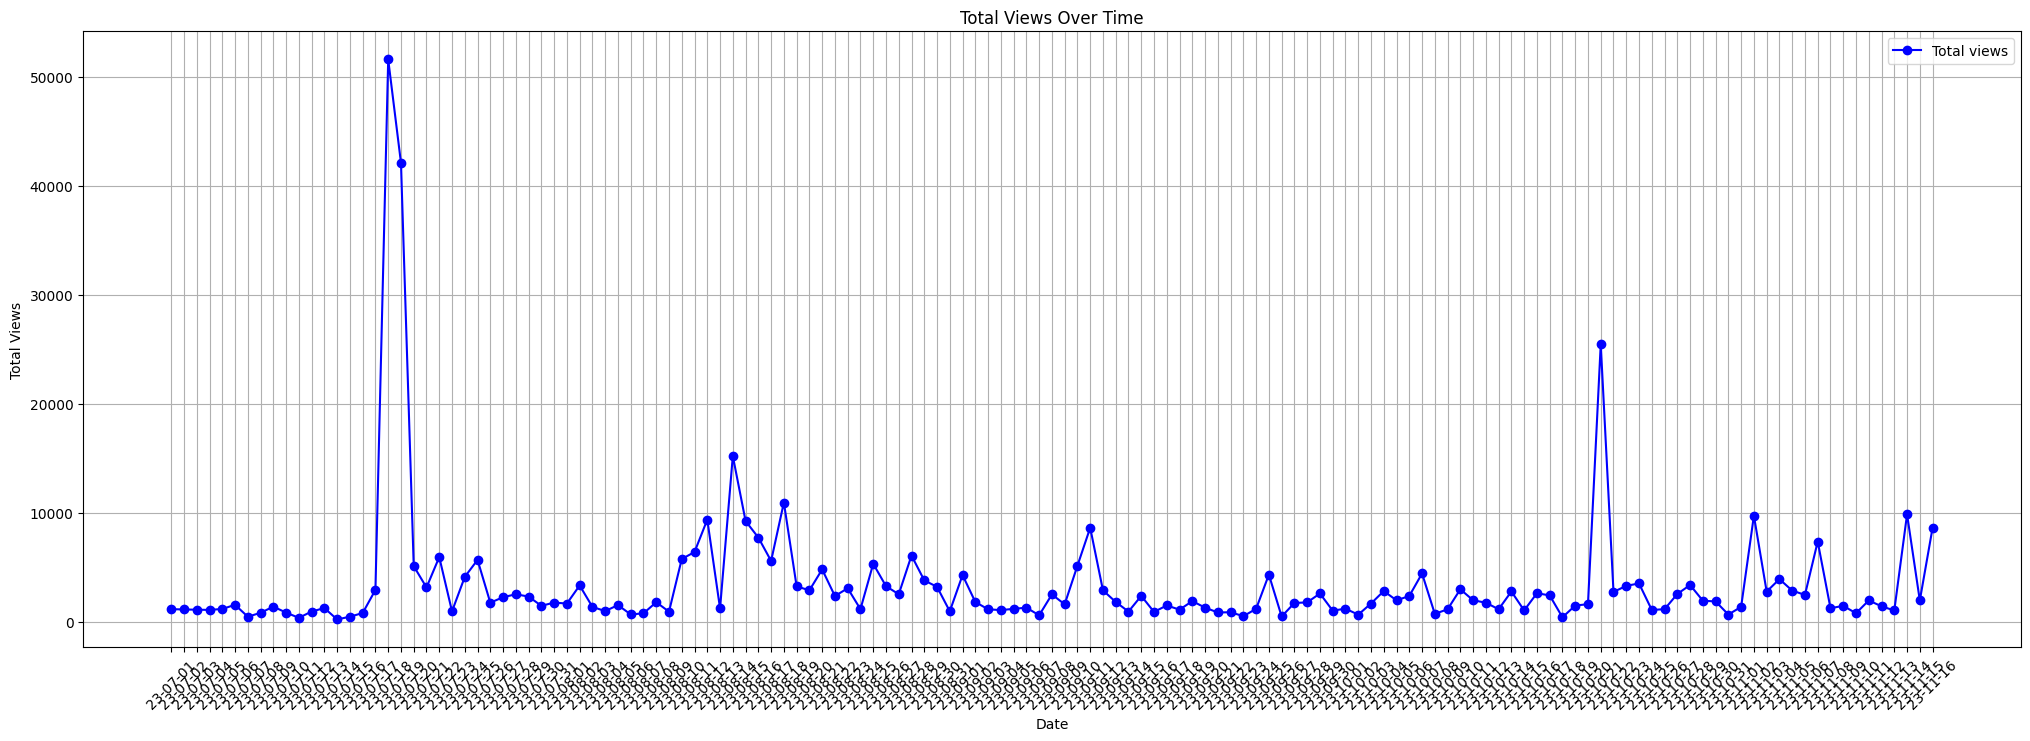

In [8]:
plot_views(santafe_data, figsize=(25, 8), parse='daily')#, criteria_date='23-08-15')

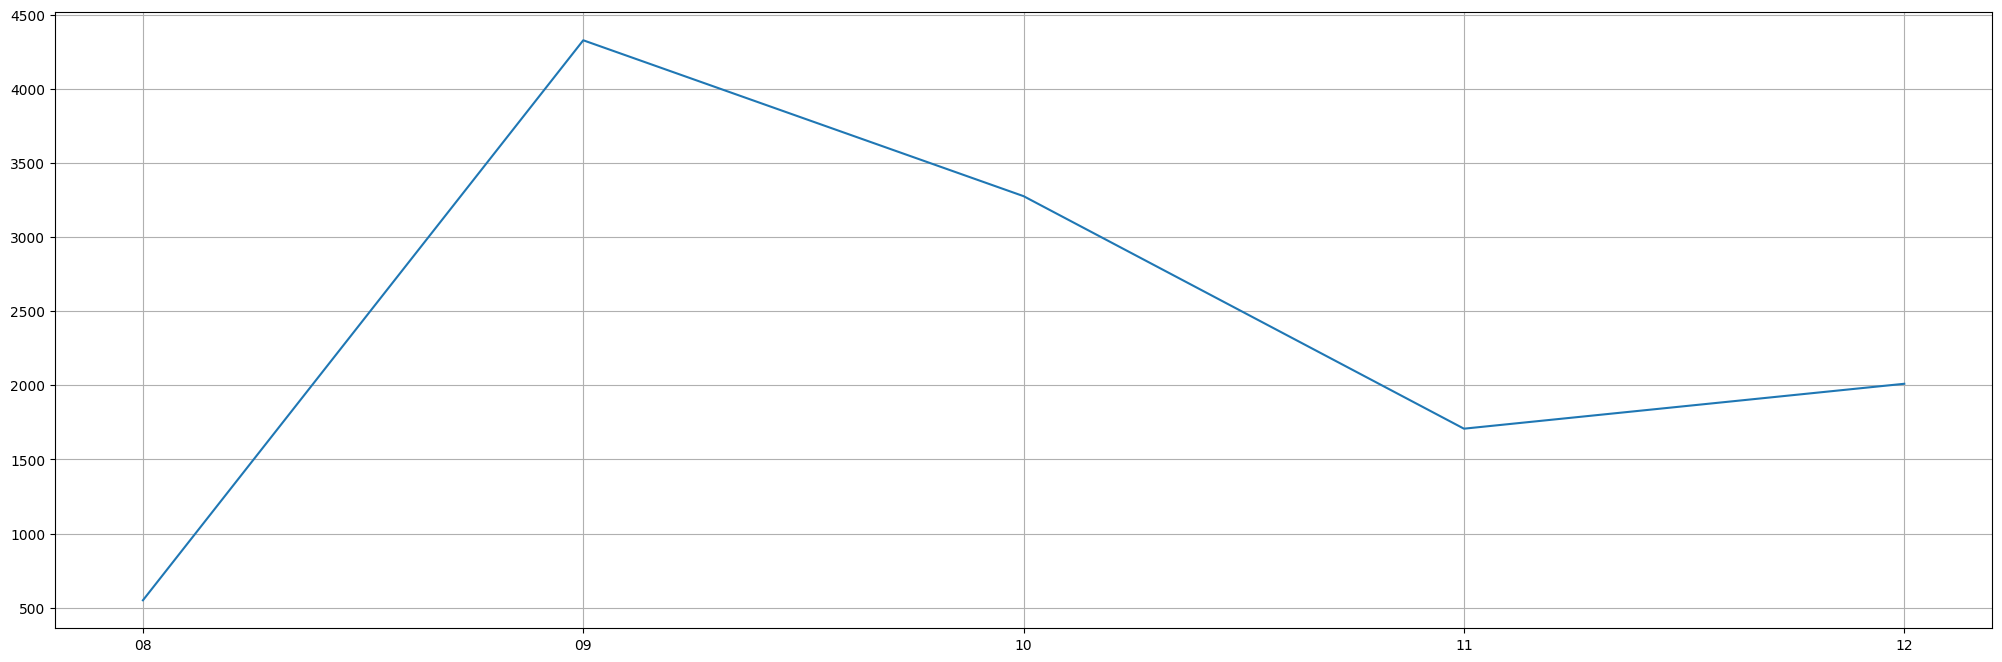

In [95]:
plt.figure(figsize=(25, 8))
plt.plot(['08', '09', '10', '11', '12'], [550,	4329,	3277,	1708,	2011])
plt.grid(True)

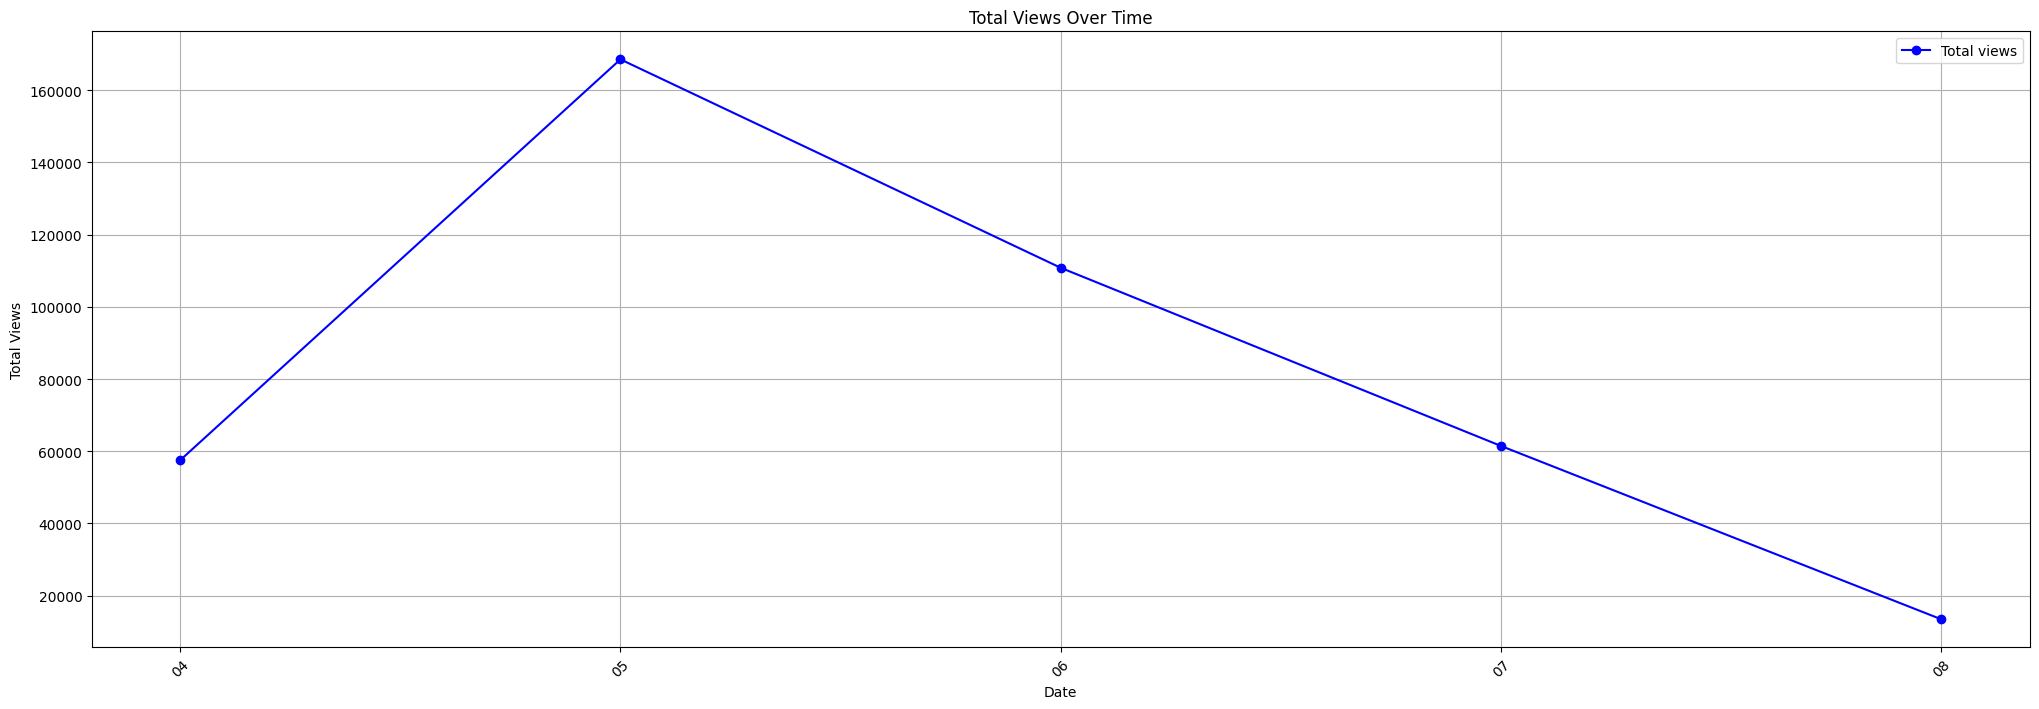

In [96]:
plot_views(gv70_data, figsize=(25, 8), parse='monthly')

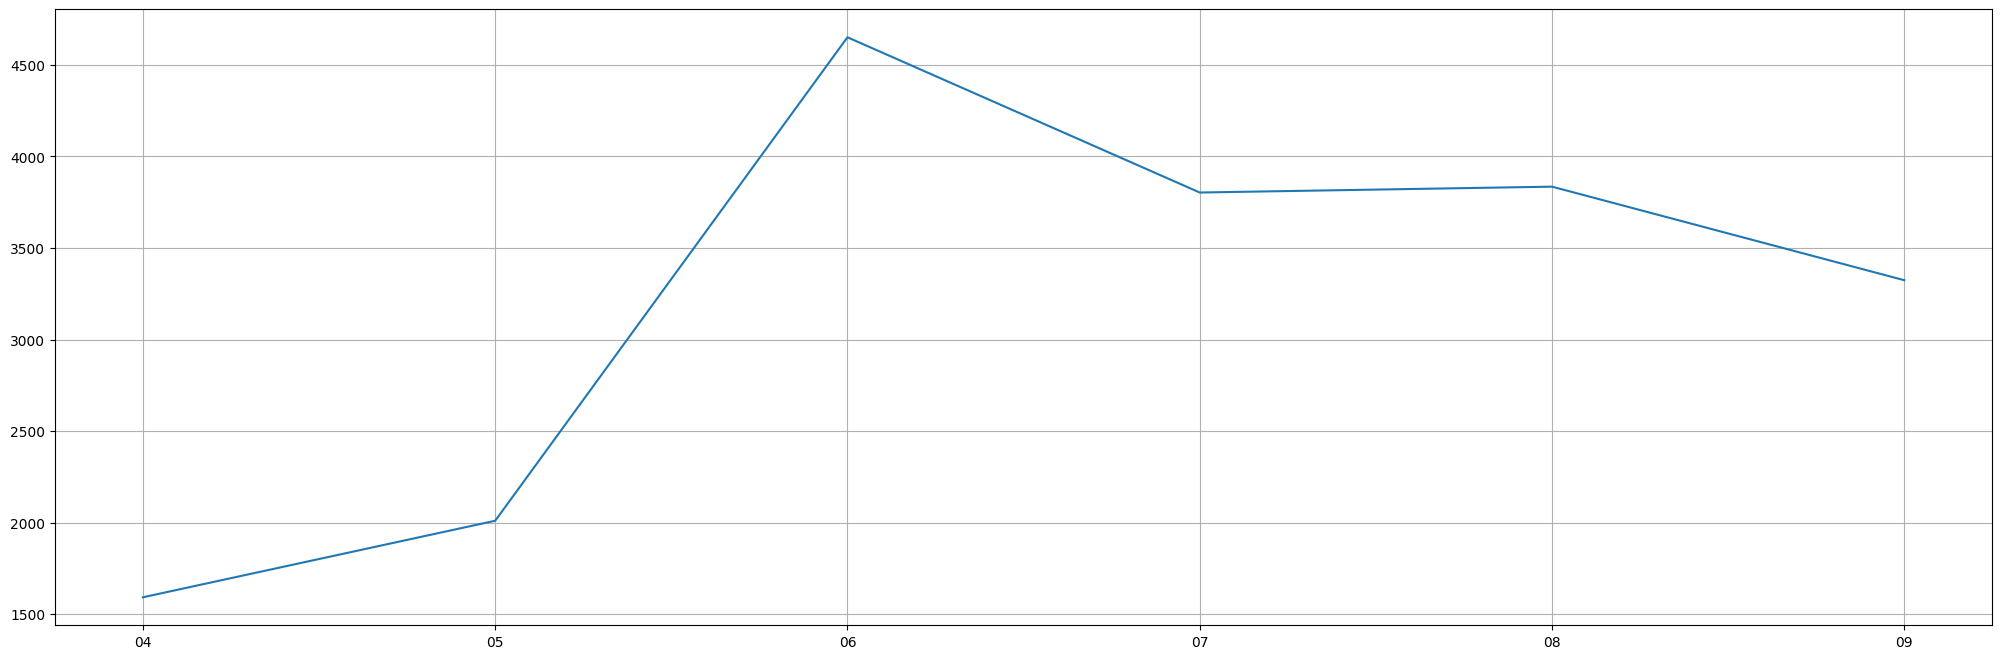

In [98]:
plt.figure(figsize=(25, 8))
plt.plot(['04', '05', '06', '07', '08', '09'], [1592,	2010,	4651,	3803,	3835,	3324])
plt.grid(True)


In [11]:
daily_batch = datetime.datetime.now().strftime("%Y-%m-%d")
daily_batch

'2025-02-17'

In [43]:
def is_time_in_range(time_str, batch_time):
  """
  입력된 시간 문자열이 현재 시간과 현재 시간의 6시간 전 사이에 있는지 판단하는 함수.

  Args:
    time_str: "%Y-%m-%d %H:%M:%S" 형식의 시간 문자열.

  Returns:
    True: 입력된 시간이 현재 시간과 현재 시간의 6시간 전 사이에 있는 경우.
    False: 입력된 시간이 현재 시간과 현재 시간의 6시간 전 사이에 없는 경우.
  """

  try:
    input_time = datetime.datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
  except ValueError:
    return False  # 잘못된 형식의 문자열

  now = datetime.datetime.strptime(batch_time, "%Y-%m-%d %H:%M:%S")
  six_hours_ago = now - datetime.timedelta(hours=6)
  print(now)
  print(input_time, "<-- Input time")
  print(six_hours_ago)

  return six_hours_ago <= input_time <= now

In [44]:
is_time_in_range('2025-02-17 16:01:45', datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2025-02-17 20:15:11
2025-02-17 16:01:45 <-- Input time
2025-02-17 14:15:11


True

In [55]:
# datetime.datetime.strptime(' '.join("2024-02-14T09:30:00".split('T')), "%y-%m-%d %H:%M:%S")
str(datetime.datetime.strptime(' '.join("2024-02-14T09:30:00".split('T')), "%Y-%m-%d %H:%M:%S"))

'2024-02-14 09:30:00'

In [61]:
def md_to_ymd(date_str:str):
    from datetime import datetime
    """
    댓글 타임스탬프의 두 가지 날짜 형식을 입력받아 "yyyy-mm-dd HH:MM:SS" 형식으로 변환합니다.
    본문 및 댓글의 날짜 형식에 대응합니다.
    
    Args:
        date_str: 변환할 날짜 문자열 ("yyyy.mm.dd HH:MM:SS" 또는 "mm.dd HH:MM:SS" 형식)

    Returns:
        "yyyy-mm-dd HH:MM:SS" 형식으로 변환된 날짜 문자열
    """
    try:
        # "yyyy.mm.dd HH:MM:SS" 형식인 경우 그대로 반환
        date_obj = datetime.strptime(date_str, "%Y.%m.%d %H:%M:%S")
        print("yyyy")
        return date_obj.strftime("%Y-%m-%d %H:%M:%S")
    
    except ValueError:
        try:
            # "mm.dd HH:MM:SS" 형식인 경우 연도를 2025로 가정하여 변환
            date_obj = datetime.strptime(date_str, "%m.%d %H:%M:%S")
            return date_obj.replace(year=datetime.now().year).strftime("%Y-%m-%d %H:%M:%S")
        except ValueError:
            return "Invalid date format"

In [62]:
md_to_ymd("2024.12.04 22:39:20")

yyyy


'2024-12-04 22:39:20'